In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
!gdown --id 1NGlXT9sIaQpyxUoT6MLKm1Pr6x8oxOvc
!pip install patool
import patoolib
import os
import shutil
#os.mkdir("NEU-CLS")
#shutil.rmtree("NEU-CLS")
patoolib.extract_archive("NEU-CLS.rar", outdir="./")

Downloading...
From: https://drive.google.com/uc?id=1NGlXT9sIaQpyxUoT6MLKm1Pr6x8oxOvc
To: /content/NEU-CLS.rar
50.7MB [00:00, 109MB/s] 
patool: Extracting NEU-CLS.rar ...
patool: running /usr/bin/unrar x -- /content/NEU-CLS.rar
patool:     with cwd='./'


PatoolError: ignored

1440 1440
360 360


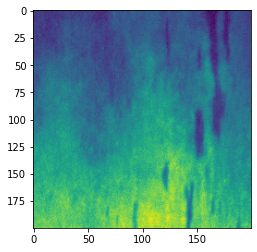

3


In [ ]:
import glob
from PIL import Image
import numpy as np


class_names = ["RS","In","Pa","Sc","PS","Cr"]

Cr = glob.glob("./NEU-CLS/Cr*.bmp")
Sc = glob.glob("./NEU-CLS/Sc*.bmp")
RS = glob.glob("./NEU-CLS/RS*.bmp")
In = glob.glob("./NEU-CLS/In*.bmp")
Pa = glob.glob("./NEU-CLS/Pa*.bmp")
PS = glob.glob("./NEU-CLS/PS*.bmp")
split = int(300*0.8)

train = Cr[:split] + Sc[:split] + RS[:split] + In[:split] + Pa[:split] + PS[:split]
train_labs = [0 for i in range(split)]+[1 for i in range(split)] +\
[2 for i in range(split)]+\
[3 for i in range(split)]+\
[4 for i in range(split)]+\
[5 for i in range(split)]


test = Cr[split:] + Sc[split:] + RS[split:] + In[split:] + Pa[split:] + PS[split:]
test_labs = [0 for i in range(300-split)]+[1 for i in range(300-split)] +\
[2 for i in range(300-split)]+\
[3 for i in range(300-split)]+\
[4 for i in range(300-split)]+\
[5 for i in range(300-split)]

print(len(train),len(train_labs))
print(len(test),len(test_labs))

i= np.random.randint(0,len(train_labs))

import matplotlib.pyplot as plt 
import cv2

im = plt.imread(train[i])
plt.imshow(im)
plt.show()
print(train_labs[i])

def get_info(fn):
  img = cv2.imread(fn,0)
  sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
  sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
  sobelxx = cv2.Sobel(sobelx,cv2.CV_64F,1,0,ksize=5)
  sobelyy = cv2.Sobel(sobely,cv2.CV_64F,1,0,ksize=5)
  grad = np.sqrt(sobelx**2+sobely**2)
  grad2 = np.sqrt(sobelxx**2+sobelyy**2)
  ang = np.arctan2(sobelx,sobely)
  outvec = [np.mean(img),np.mean(grad),np.mean(sobely),
            np.mean(sobelx),np.std(img),np.std(grad),np.mean(ang),
            np.mean(grad2),np.std(grad2)]
  return outvec

def get_1st_derivative(fn):
  img = cv2.imread(fn,0)
  sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
  sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
  sobelxx = cv2.Sobel(sobelx,cv2.CV_64F,1,0,ksize=5)
  sobelyy = cv2.Sobel(sobely,cv2.CV_64F,1,0,ksize=5)
  grad = np.sqrt(sobelx**2+sobely**2)
  grad2 = np.sqrt(sobelxx**2+sobelyy**2)
  outvec = [np.mean(img),np.mean(grad),np.mean(sobely),
            np.mean(sobelx),np.std(img),np.std(grad),np.mean(ang),
            np.mean(grad2),np.std(grad2)]

vecs =[]

for f in train:
  vecs.append(get_info(f))

vecs2 =[]

for f in test:
  vecs2.append(get_info(f))

(1440, 9)
1440


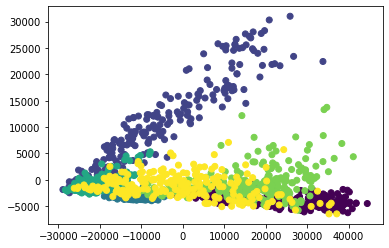

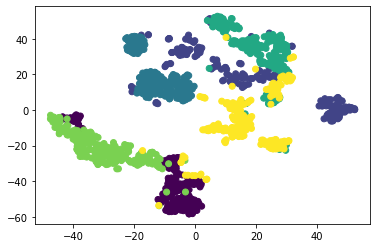

In [ ]:
vecs = np.array(vecs)

print(vecs.shape)
print(len(train_labs))

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=2)

s =pca.fit_transform(vecs)

plt.scatter(s[:,0],s[:,1],c=train_labs)

plt.show()

tsne = TSNE(n_components=2)
ss = StandardScaler(with_mean=False)

scaled_feats = ss.fit_transform(vecs)

spc = tsne.fit_transform(scaled_feats)

plt.scatter(spc[:,0],spc[:,1],c=train_labs)

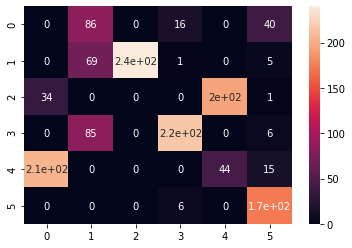

In [ ]:
from sklearn.cluster import KMeans
import seaborn
km = KMeans(n_clusters=6)

km.fit(spc)

labs = km.labels_

conf = np.zeros((6,6))

for i,j in zip(labs,train_labs):
  conf[i][j]+=1

seaborn.heatmap(conf,annot=True)

[[ 86.   0.   0.  16.   0.  40.]
 [ 69. 240.   0.   1.   0.   5.]
 [  0.   0. 196.   0.  34.   1.]
 [ 85.   0.   0. 217.   0.   6.]
 [  0.   0.  44.   0. 206.  15.]
 [  0.   0.   0.   6.   0. 173.]]
0.7763888888888889


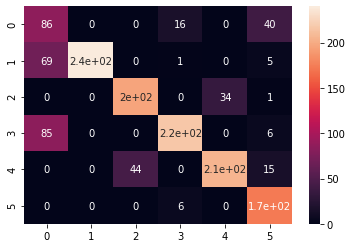

In [ ]:
conf2 = np.zeros((6,6))

for i in range(6):
  rowmax = np.argmax(conf[i])
  conf2[:,i] = conf[:,rowmax]
seaborn.heatmap(conf2,annot=True)

print(conf2)
print((conf2[0][0] + conf2[1][1]+conf2[2][2] + conf2[3][3] + conf2[4][4] + conf2[5][5])/np.sum(conf2))

0.9694444444444444


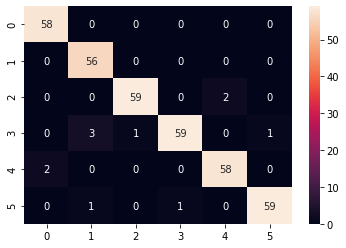

In [ ]:
import seaborn
from sklearn.ensemble import RandomForestClassifier

clas = RandomForestClassifier()

clas.fit(vecs,train_labs)

print(clas.score(vecs2,test_labs))

labs = clas.predict(vecs2)

conf = np.zeros((6,6))

for i,j in zip(labs,test_labs):
  conf[i][j]+=1


seaborn.heatmap(conf,annot=True)

In [ ]:
imp = clas.feature_importances_
feats = np.array(['mean_img','mean_grad','mean_grad_y',
            'mean_sobel_x','std_img','std_grad','mean_ang',
            'mean_grad2','std_grad2'])
sor = np.argsort(imp)[::-1]
print(imp[sor])
print(feats[sor])
print(np.array(vecs).shape)


[0.21208985 0.1701783  0.15796972 0.14765531 0.11696608 0.10805175
 0.03940244 0.02556264 0.02212391]
['std_img' 'mean_grad' 'std_grad' 'mean_grad2' 'mean_img' 'std_grad2'
 'mean_sobel_x' 'mean_ang' 'mean_grad_y']
(1440, 9)


0.9583333333333334


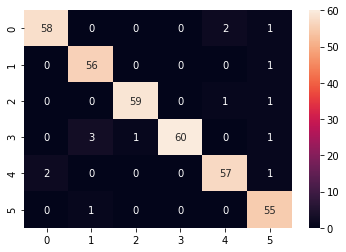

In [ ]:
def get_info(fn):
  img = cv2.imread(fn,0)
  sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
  sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
  sobelxx = cv2.Sobel(sobelx,cv2.CV_64F,1,0,ksize=5)
  sobelyy = cv2.Sobel(sobely,cv2.CV_64F,1,0,ksize=5)
  grad = np.sqrt(sobelx**2+sobely**2)
  grad2 = np.sqrt(sobelxx**2+sobelyy**2)
  ang = np.arctan2(sobelx,sobely)
  outvec = [np.mean(img),np.mean(grad),np.std(img),np.std(grad),
            np.mean(grad2),np.std(grad2)]
  return outvec


vecs =[]

for f in train:
  vecs.append(get_info(f))

vecs2 =[]

for f in test:
  vecs2.append(get_info(f))

clas = RandomForestClassifier(max_depth=7,n_estimators=100)

clas.fit(vecs,train_labs)

print(clas.score(vecs2,test_labs))

labs = clas.predict(vecs2)

conf = np.zeros((6,6))

for i,j in zip(labs,test_labs):
  conf[i][j]+=1


seaborn.heatmap(conf,annot=True)

Text(0.5, 1.0, 'c')

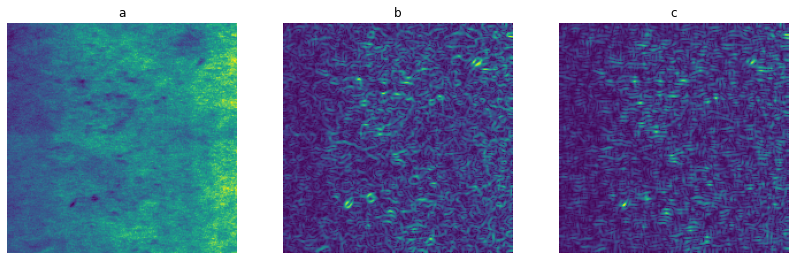

In [ ]:
img = cv2.imread("./NEU-CLS/RS_1.bmp",0)


fig,axs = plt.subplots(nrows=1,ncols=3)
fig.set_size_inches(14, 8)
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
grad = np.sqrt(sobelx**2+sobely**2)
sobelxx = cv2.Sobel(sobelx,cv2.CV_64F,1,0,ksize=5)
sobelyy = cv2.Sobel(sobely,cv2.CV_64F,0,1,ksize=5)
grad2 = np.sqrt(sobelxx**2+sobelyy**2)

axs[0].imshow(img)
axs[0].axis('off')
axs[0].set_title('a')

axs[1].imshow(grad)
axs[1].axis('off')
axs[1].set_title('b')

axs[2].imshow(grad2)
axs[2].axis('off')
axs[2].set_title('c')

